# Import Libraries

In [1]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Data overview after preprocessing

In [2]:
df = pd.read_csv('final_cleaned_data.csv')
df.head()

,Text,Text_Cleansing,Text_Preprocessing,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nya nya...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,betapa bahagia nya unbog paket barang nya bagu...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


Cek Isi berdasarkan index

In [3]:
idx = 787
print('Teks Awal :',df['Text'][idx])
print('Teks Preprocessed :',df['Text_Preprocessing'][idx])

Teks Awal : kebaikan
Teks Preprocessed : baik


# Assign to specific x dan y

In [4]:
X = df['Text_Preprocessing'].astype(str)
max_features = 100000

# Tokenisasi
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Padding
X = pad_sequences(X, maxlen=55)

# Menampilkan bentuk akhir dari data
X.shape

(11000, 55)

In [5]:
import pickle

with open('Text_Preprocessing.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Text_Preprocessing.pickle has created!')

Text_Preprocessing.pickle has created!


# Mapping and Assign Label y

In [6]:
# Dilakukan proses mapping karna label y > 2
sentiment_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df['Sentiment'].map(sentiment_encode).values
print(y)
print(y.shape)

[2 1 2 ... 1 0 2]
(11000,)


# One Hot Encoder

In [7]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(y.reshape(-1,1))
# y_hot = onehot.transform(y.reshape(-1,1))
y_hot = onehot.transform(y.reshape(-1,1)).toarray()
print(y_hot.shape)

(11000, 3)


In [8]:
# Cek Array y_hot 1-10
y_hot[0:10]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [9]:
import pickle

with open('y_label.pickle', 'wb') as handle:
    pickle.dump(y_hot, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_label.pickle has created!')

y_label.pickle has created!


# Splitting Data

In [11]:
# from sklearn.model_selection import train_test_split

# file = open("x_pad_sequences.pickle",'rb')
# X = pickle.load(file)
# file.close()

# file = open("y_labels.pickle",'rb')
# y_hot = pickle.load(file)
# file.close()

# X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2, random_state=1)

In [10]:
#dataset split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_hot, test_size=0.20, random_state=1)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(8800, 55) (8800, 3)
(2200, 55) (2200, 3)


# Modelling

### 1. NN (Neural Network)

a. Arsitektur NN

In [28]:
embed_dim = 50  # harus diatas 10
maxlen = 55

model_nn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_dim, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Definisi loss function dan callback
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

# Definisi optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.005)

# Kompilasi model
model_nn.compile(optimizer=sgd,
                 loss=loss_fn,
                 metrics=['accuracy'])

# Menampilkan ringkasan model
model_nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

b. Training

In [29]:
# Melatih model
history = model_nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[es],
    batch_size=64
)

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5489 - loss: 1.0510 - val_accuracy: 0.5859 - val_loss: 0.9505
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5862 - loss: 0.9311 - val_accuracy: 0.5859 - val_loss: 0.8942
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5774 - loss: 0.8928 - val_accuracy: 0.5859 - val_loss: 0.8559
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6003 - loss: 0.8613 - val_accuracy: 0.6550 - val_loss: 0.8230
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6540 - loss: 0.8236 - val_accuracy: 0.6832 - val_loss: 0.7976
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6670 - loss: 0.8110 - val_accuracy: 0.6823 - val_loss: 0.7806
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6716 - loss: 0.7994 - val_accuracy: 0.6836 - val_loss: 0.7720
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6713 - loss: 0.7939 -

In [30]:
result = history.history
n_epochs = np.arange(0, len(result['accuracy']))

c. Plot Accuracy Epoch (NN)

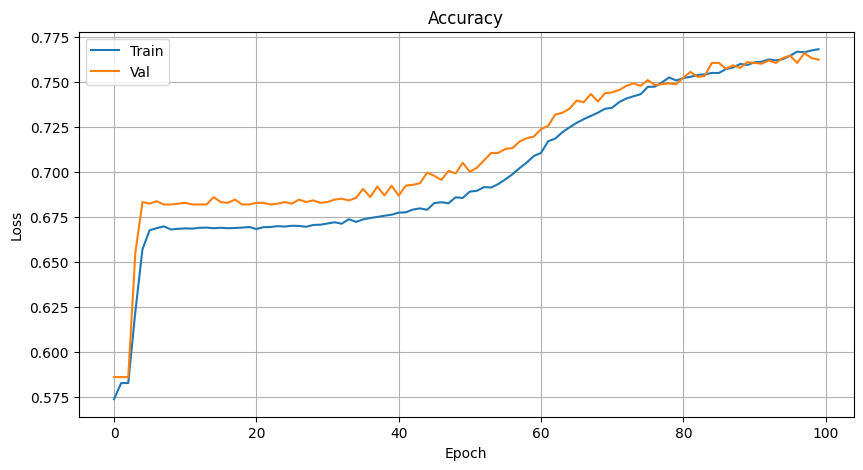

In [31]:
plt.figure(figsize=(10,5))
plt.title('Accuracy')
plt.plot(n_epochs, result['accuracy'])
plt.plot(n_epochs, result['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

d. Plot Loss Epoch (NN)

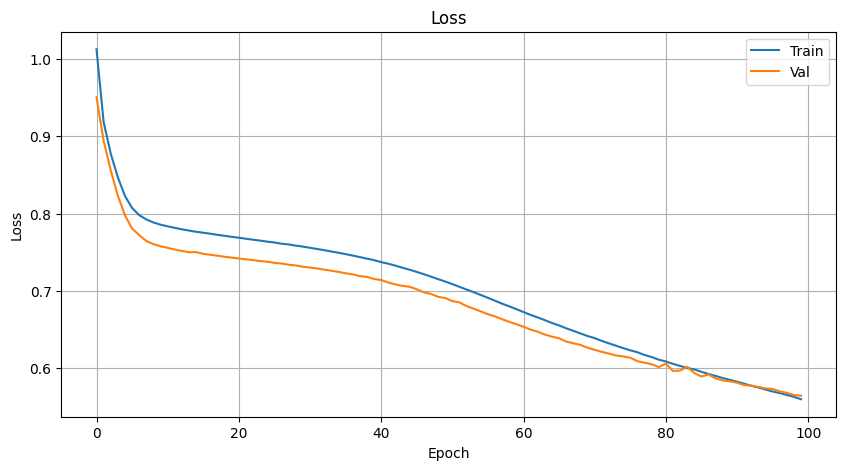

In [32]:
plt.figure(figsize=(10,5))
plt.title('Loss')
plt.plot(n_epochs, result['loss'])
plt.plot(n_epochs, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

c. Evaluasi

In [35]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

y_pred = model_nn.predict(X_val)

y_pred_classes = y_pred.argmax(axis=1)
y_val_classes = y_val.argmax(axis=1)
print("Testing selesai")
print(classification_report(y_val_classes, y_pred_classes, zero_division=0.0))

accuracy = accuracy_score(y_val_classes, y_pred_classes)
print('Accuracy Score SDG (0.075) :', round(accuracy, 2))


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       672
           1       0.00      0.00      0.00       239
           2       0.89      0.89      0.89      1289

    accuracy                           0.76      2200
   macro avg       0.49      0.56      0.52      2200
weighted avg       0.70      0.76      0.73      2200

Accuracy Score SDG (0.075) : 0.76


f. Cross Validation Score

In [36]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=1,shuffle=True)

accuracies = []

label = y_hot

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = label[data[0]]

    data_test    = X[data[1]]
    target_test  = label[data[1]]


    model_nn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
    loss='CategoricalCrossentropy',
    metrics=['accuracy'])

    history = model_nn.fit(
    data_train,
    target_train,
    epochs = 100,
    validation_data = (data_test, target_test),
    callbacks=[es],
    batch_size=64,
    verbose=1,
    )

    predictions = model_nn.predict(X_val)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,2))

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7679 - loss: 0.5638 - val_accuracy: 0.7655 - val_loss: 0.5648
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7657 - loss: 0.5590 - val_accuracy: 0.7632 - val_loss: 0.5605
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7708 - loss: 0.5507 - val_accuracy: 0.7705 - val_loss: 0.5635
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7689 - loss: 0.5553 - val_accuracy: 0.7664 - val_loss: 0.5618
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7702 - loss: 0.5537 - val_accuracy: 0.7673 - val_loss: 0.5555
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7681 - loss: 0.5505 - val_accuracy: 0.7659 - val_loss: 0.5554
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7664 - loss: 0.5492 - val_accuracy: 0.7723 - val_loss: 0.5565
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7721 - loss: 0.5454 - 

# Save Model

In [37]:
model_nn.save('nn_model.h5')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [41]:
def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    return text

class_labels = ['negatif', 'netral', 'positif']

original_text = '08:30 : kedatangan presiden ri dan rombongan di gate 2 , terminal 3 disambut oleh menteri perhubungan , menteri bumn , gubernur banten , dirjen perkeretaapian kemhub , dirut ap2 , dirut pt kami , dan dirut railink'
cleaned_text = cleansing(original_text)
text_sequence = tokenizer.texts_to_sequences([cleaned_text])
text_padded = pad_sequences(text_sequence, maxlen=55)

result = model_nn.predict(text_padded)[0]
predicted_class = np.argmax(result)
predicted_label = class_labels[predicted_class]

print('Sentiment :')
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Sentiment :
netral


In [27]:
# plt.figure(figsize=(10,5))
# plt.title('Loss')
# plt.plot(n_epochs, result['loss'])
# plt.plot(n_epochs, result['val_loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Val'])
# plt.grid()
# plt.show()